# グローバー探索量子アルゴリズムをとことん実装する

In [1]:
#!pip install qulacs
#!pip install qulacsvis
#!pip install matplotlib
#!pip install numpy
#!pip install scipy

グローバー探索アルゴリズムは、ソートされていないN個のデータがあったときに、$O(\sqrt N)$回のクエリで目的のデータにアクセスするための方法である。古典コンピュータでは$O(N)$回のクエリが必要であるので、$N$が$n$ビットのランダムアクセスメモリ（$N=2^n$）のような場合には指数的な加速を可能とする。例えば、ある効率よく計算できるブール関数$f:\{0,1\}^n \rightarrow \{ 0,1\}$に対して、$f(x)=0$となる$x \in \{0,1\}^n$を見つけるような場合に利用できる。古典アルゴリズムの全探索部分をすべからく平方根（quadratic）に高速化してくれるので、SAT問題など古典ベストアルゴリズムを量子を用いてさらに加速することができる。

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs.gate import H, X, Z
from qulacs.state import inner_product
from qulacsvis import circuit_drawer

In [3]:
def show_distribution(state,nqubits):
    plt.bar([i for i in range(pow(2,nqubits))],abs(state.get_vector()))
    plt.show()

初期状態としてすべてのビット列が重ね合わさった状態を準備する。

In [4]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard = QuantumCircuit(nqubits)

for i in range(nqubits):
    Hadamard.add_gate(H(i))

Hadamard.update_quantum_state(state)
#state.get_vector()    

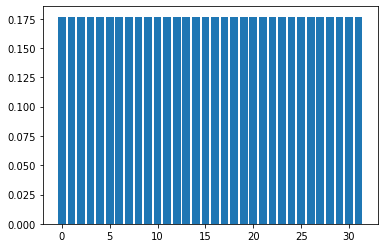

In [5]:
show_distribution(state,nqubits)

グローバーアルゴリズムでは、

- 特定の target 状態の係数に-1を付けるフリップ演算子 target_flip
- 初期状態のすべてのビット列が重ね合わさった状態（$|+\rangle ^{\otimes n}$）に-1をつけるフリップ演算子 initial_flip

を繰り返し作用させることによって初期状態から終状態の２状態間の回転を誘導することになる。ここでは target 状態としてすべて1の状態 $|11...1\rangle$ を選んだ。  
実際には $f(x)=0$ を満たす状態を取り出す場合に利用する。この場合、関数 $f$ を量子コンピュータ上で実行し、$\sum_x |x\rangle  \rightarrow \sum_x (-1)^{f(x) \oplus 1}|x\rangle$という量子演算がフリップ演算子となる。$f$を構成する部分のゲート数は$n$に対して多項式（$N=2^n$に対しては対数多項式）であることを前提とする。

qulacsの特殊ゲート `to_matrix_gate` を使うと好きな `control_index` の量子ビットが好きなビット値 `control_with_value` の場合に作用する制御量子演算を実現できる。今回は、nqubits-1番目までの量子ビットがすべて1の場合にnqubits番目の量子ビットにZを作用させる（$|111...1 \rangle$のみ-1をつけるフリップ演算子を定義する）。

In [6]:
target_flip = to_matrix_gate(Z(nqubits-1))
# 1st-qubitが0の場合だけゲートを作用
for i in range(nqubits-1):
    control_index = i
    control_with_value = 1
    target_flip.add_control_qubit(control_index, control_with_value)

実際そのような作用になっていることを確認しておく。

In [7]:
flipped_state = state.copy()
target_flip.update_quantum_state(flipped_state)
print(flipped_state.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


同様にして、初期状態のフリップ演算子を作る。すべての量子ビットにアダマール演算とパウリX演算を作用（target_flipの前後に共役に作用）させることで初期状態のフリップ演算子が作れる。

In [8]:
initial_flip = QuantumCircuit(nqubits)

for i in range(nqubits):
    initial_flip.add_gate(H(i))
    initial_flip.add_gate(X(i))

initial_flip.add_gate(target_flip)

for i in range(nqubits):
    initial_flip.add_gate(X(i))
    initial_flip.add_gate(H(i))

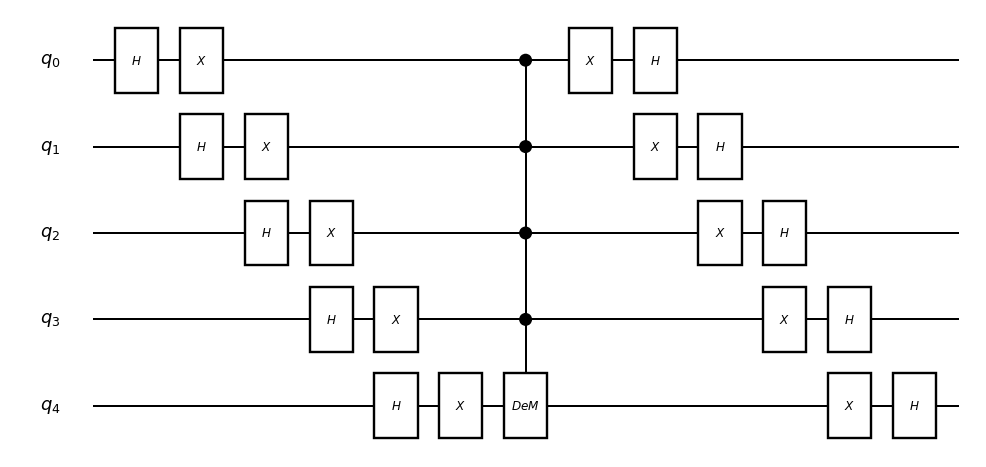

In [9]:
circuit_drawer(initial_flip, "mpl")

フリップ演算子を作用させて確率分布の変化を見よう。全部1の状態（一番右側）の確率が大きくなっている。

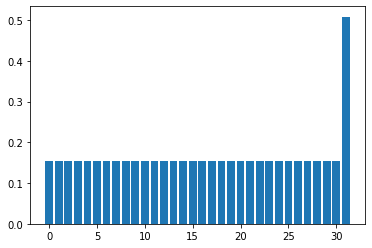

In [10]:
#初期状態の準備
state.set_zero_state()
Hadamard.update_quantum_state(state)

#フリップ演算子を作用
target_flip.update_quantum_state(state)
initial_flip.update_quantum_state(state)
show_distribution(state,nqubits)

これを何回か繰り返して、target状態の確率がどのように変化するか見ておく。

target状態


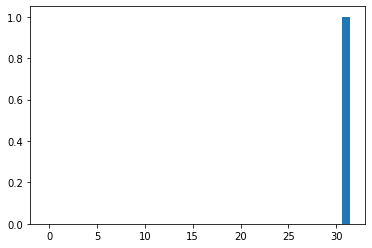

繰り返し回数: 1回目
target状態との内積: 0.5082329989778305


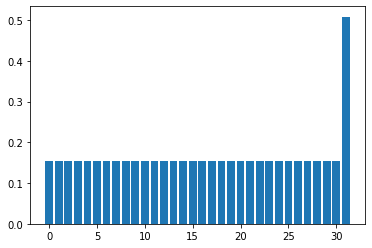

繰り返し回数: 2回目
target状態との内積: 0.7761601777867947


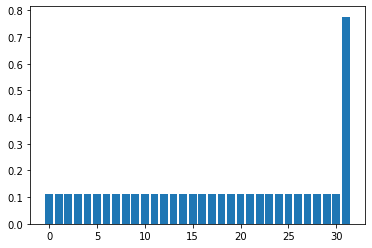

繰り返し回数: 3回目
target状態との内積: 0.9470673343724091


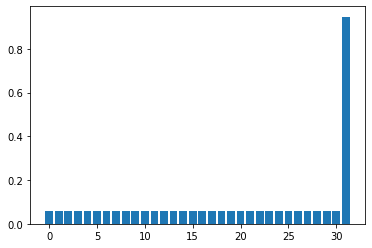

繰り返し回数: 4回目
target状態との内積: 0.9995910741614723


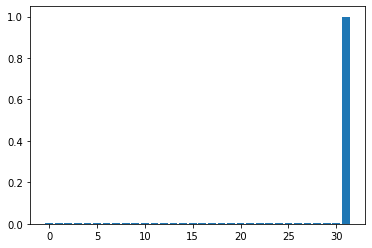

In [11]:
state.set_zero_state()

#内積を評価するために target stateを作っておく
target_state = QuantumState(nqubits)
target_state = state.copy()
for i in range(nqubits):
    X(i).update_quantum_state(target_state)

#すべての計算基底の重ね合わせ状態を作る
Hadamard.update_quantum_state(state)
print("target状態")
show_distribution(target_state,nqubits)

for i in range(4):
    target_flip.update_quantum_state(state)
    initial_flip.update_quantum_state(state)
    print(f"繰り返し回数: {i+1}回目")
    print(f"target状態との内積: {np.linalg.norm(inner_product(state, target_state))}")
    show_distribution(state,nqubits)

4回でほぼ確率１で target 状態を得ることができた。

前準備ができたので、量子ビット数を変えて、target状態が得られるのに必要な繰り返し回数を計算してみる

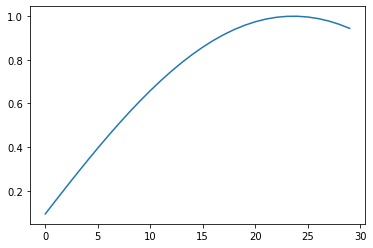

In [12]:
nqubits = 10
state = QuantumState(nqubits)
state.set_zero_state()

# transversal Hadamard gateを定義する
Hadamard = QuantumCircuit(nqubits)
for i in range(nqubits):
    Hadamard.add_gate(H(i))

#initial_flipとtarget_flipを定義する。
target_flip = to_matrix_gate(Z(nqubits-1))
# 1st-qubitが0の場合だけゲートを作用
for i in range(nqubits-1):
    control_index = i
    control_with_value = 1
    target_flip.add_control_qubit(control_index, control_with_value)

initial_flip = QuantumCircuit(nqubits)

for i in range(nqubits):
    initial_flip.add_gate(H(i))
    initial_flip.add_gate(X(i))

initial_flip.add_gate(target_flip)

for i in range(nqubits):
    initial_flip.add_gate(X(i))
    initial_flip.add_gate(H(i))



#内積を評価するために target stateを作っておく
target_state = QuantumState(nqubits)
target_state = state.copy()
for i in range(nqubits):
    X(i).update_quantum_state(target_state)

#すべての計算基底の重ね合わせ状態を作る
Hadamard.update_quantum_state(state)

result = []

for i in range(30):
    target_flip.update_quantum_state(state)
    initial_flip.update_quantum_state(state)
    result.append(np.linalg.norm(inner_product(state, target_state)))

plt.plot(result)
plt.show()

約25回くらいでほぼ確率1でtarget状態が得られている。確率の増加は、サイン関数の２乗のような振る舞いになっている。これは、グローバー探索が、初期状態とtarget状態の間を一定の角度で回転している操作になっているからである。

量子ビット数を増やして、target状態の得られる確率が最大となるステップ数を調べよう。(※実行結果が出るまで、数分かかります)

In [13]:
result = []
num_samp = 16
for j in range(num_samp):
    nqubits = j + 5
    state = QuantumState(nqubits)
    state.set_zero_state()

    # transversal Hadamard gateを定義する
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))

    #initial_flipとtarget_flipを定義する。
    target_flip = to_matrix_gate(Z(nqubits-1))
    # 1st-qubitが0の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        target_flip.add_control_qubit(control_index, control_with_value)

    initial_flip = QuantumCircuit(nqubits)

    for i in range(nqubits):
        initial_flip.add_gate(H(i))
        initial_flip.add_gate(X(i))

    initial_flip.add_gate(target_flip)

    for i in range(nqubits):
        initial_flip.add_gate(X(i))
        initial_flip.add_gate(H(i))



    #内積を評価するために target stateを作っておく
    target_state = QuantumState(nqubits)
    target_state = state.copy()
    for i in range(nqubits):
        X(i).update_quantum_state(target_state)

    #すべての計算基底の重ね合わせ状態を作る
    Hadamard.update_quantum_state(state)

    tmp = 0
    flag = 0
    num_iter = 0
    while flag == 0 or num_iter > 1000:
        num_iter += 1
        target_flip.update_quantum_state(state)
        initial_flip.update_quantum_state(state)
        suc_prob = np.linalg.norm(inner_product(state, target_state))
        if tmp < suc_prob:
            tmp = suc_prob
        else: 
            flag = 1
    result.append(num_iter)

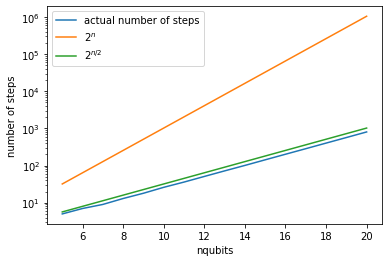

In [14]:
#計算結果の可視化

#実際のステップ数
plt.plot([i+5 for i in range(num_samp)],result, label="actual number of steps")
#2^n でスケール
plt.plot([i+5 for i in range(num_samp)],[pow(2,i+5) for i in range(num_samp)], label="$2^n$")
#2^(n/2)でスケール
plt.plot([i+5 for i in range(num_samp)],[pow(2,(i+5)/2) for i in range(num_samp)], label="$2^{n/2}$")

plt.yscale('log')
plt.xlabel("nqubits")
plt.ylabel("number of steps")
plt.legend()
plt.show()

ステップ数が$2^{n/2}$でスケールしていることがわかった。